## Dataset Information

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## Import modules

In [14]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
np.random.seed(43)
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def show_plot(data_df : pd.DataFrame):

    var = data_df.columns.values

    i = 0
    t0 = data_df.loc[data_df['Class'] == 0]
    t1 = data_df.loc[data_df['Class'] == 1]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(8,4,figsize=(16,28))

    for feature in var:
        i += 1
        plt.subplot(8,4,i)
        sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
        sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

## Oversampling function

V1~V28은 정규분포를 따른다고 가정 ($\because$ LLN) 

$N_{minority}\sim(\mu,\sigma^2)$

각 열마다 minority class에서의 정규분포에서 랜덤 샘플링


In [49]:
def over_sampling(X_set, y_set, r = 1):
    
    data_df = pd.concat([X_set, y_set], axis=1)

    y_predict_time = X_set['Time']
    x_predict_time = X_set.drop(["Time"],axis = 1)
    x_predict_time["Class"] = y_set
    
    linear = LinearRegression(fit_intercept=True)
    linear.fit(x_predict_time,y_predict_time)
    
    n = len(data_df.loc[data_df['Class'] == 0])
    k1 = len(data_df.loc[data_df['Class'] == 1])
    k2 = math.ceil(n*r)-k1

    m = len(data_df['Class'])
    t1 = data_df.loc[data_df['Class'] == 1]
    col_list = list(data_df.columns)
    df_sample = pd.DataFrame([], index = range(m,m+k2))
    col_list.remove("Time")
    for col in col_list:
        mu = t1[col].mean()
        sig = t1[col].std()
        
        df_sample[col] = np.random.normal(loc = mu, scale = sig, size = k2)
    
    predicted_time = linear.predict(df_sample)
    df_sample["Time"] = predicted_time
    df_sample["Time"] = df_sample["Time"].astype(int)
    df_sample['Time'] %= 86397
    df_sample['Class'] = 1
        
    
    merged_df = pd.concat([data_df, df_sample])
    X_sample = merged_df.drop(["Class"], axis = 1)
    y_sample = merged_df["Class"]
    
    return (X_sample, y_sample)

In [4]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Define the oversampler
oversampler = RandomOverSampler(sampling_strategy='minority')
#SMOTE
oversampler = SMOTE()

''' 
kind: A string parameter that specifies the type of SMOTE to use. The options are 'regular', 'borderline1', 'borderline2', 'svm', or 'all'. The default is 'regular'.
out_step: A float parameter that specifies the step size when interpolating new samples. The default is 0.5.
m_neighbors: An integer parameter that specifies the number of nearest neighbors to use when selecting minority class samples to oversample. The default is 5.
svm_estimator: An object parameter that specifies the estimator object used for the SVM-based SMOTE variant. The default is None.
n_jobs: The number of CPU cores to use for parallelization. The default is 1.
verbose: A verbosity level for logging. The default is 0.
'''
# undersampling
undersampler = RandomUnderSampler(sampling_strategy='majority')

# Fit and transform the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

#X_resampled, y_resampled = undersampler.fit_resample(X, y)

NameError: name 'X' is not defined

## Loading the dataset

In [20]:
df = pd.read_csv('creditcard.csv')
df['Time'] %= 86397
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,86389.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,86390.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,86391.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,86391.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [10]:
df.Time.isna().sum()

0

In [50]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.2,random_state = 42)
x_train = train.drop(['Class'],axis = 1)
y_train = train['Class']


In [12]:
print(x_train.shape, y_train.shape)
print(x_train.columns)

(227845, 30) (227845,)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


In [51]:
x_train, y_train = over_sampling(x_train,y_train)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_train.columns)

(454902, 30) (454902,)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


In [52]:
#print(x_train.Time.value_counts())
print(x_train["Time"][x_train.Time.idxmax()])
print(x_train["Time"][x_train.Time.idxmin()])


86396.0
0.0


In [9]:
# statistical info
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,52337.490908,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,21049.639663,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,38154.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,54040.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,69588.000000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,86395.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
# datatype info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<Figure size 640x480 with 0 Axes>

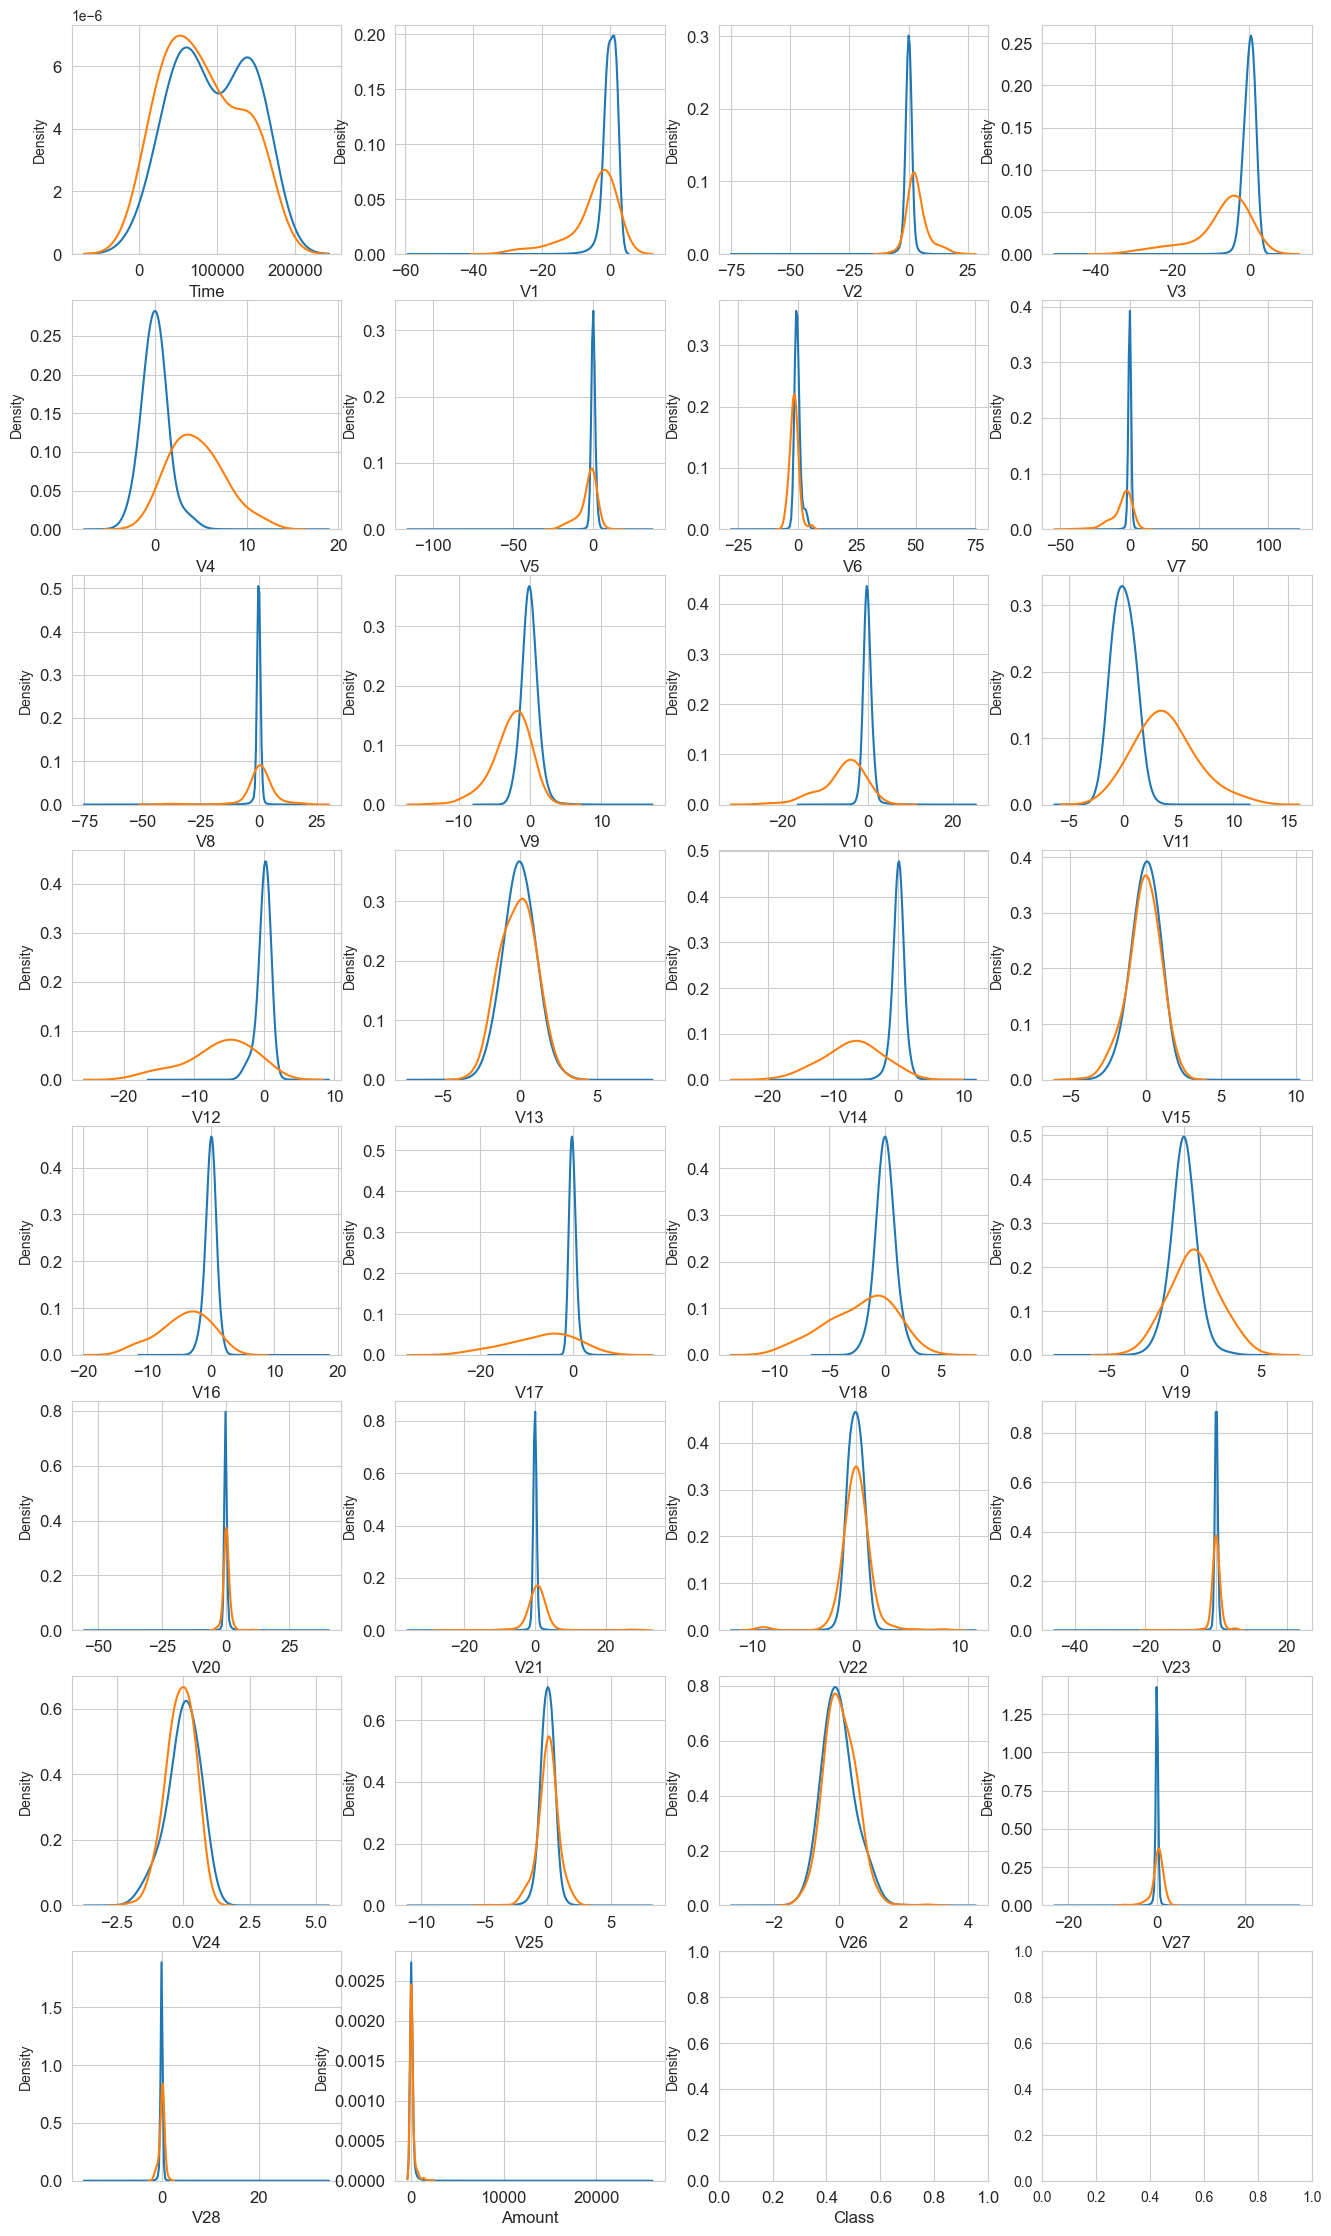

In [7]:
show_plot(df);

## Preprocessing the dataset

In [6]:
# check for null values
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## Exploratory Data Analysis

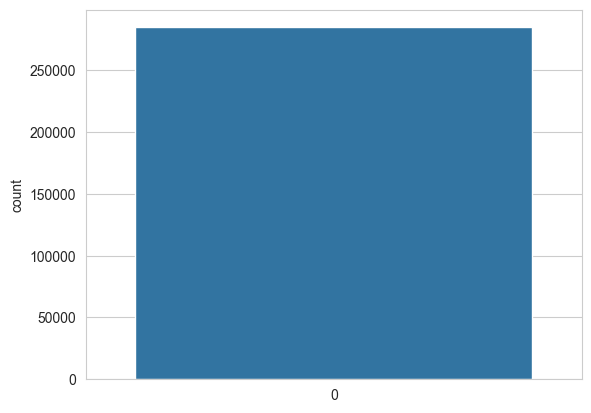

In [8]:
sns.countplot(df['Class']);

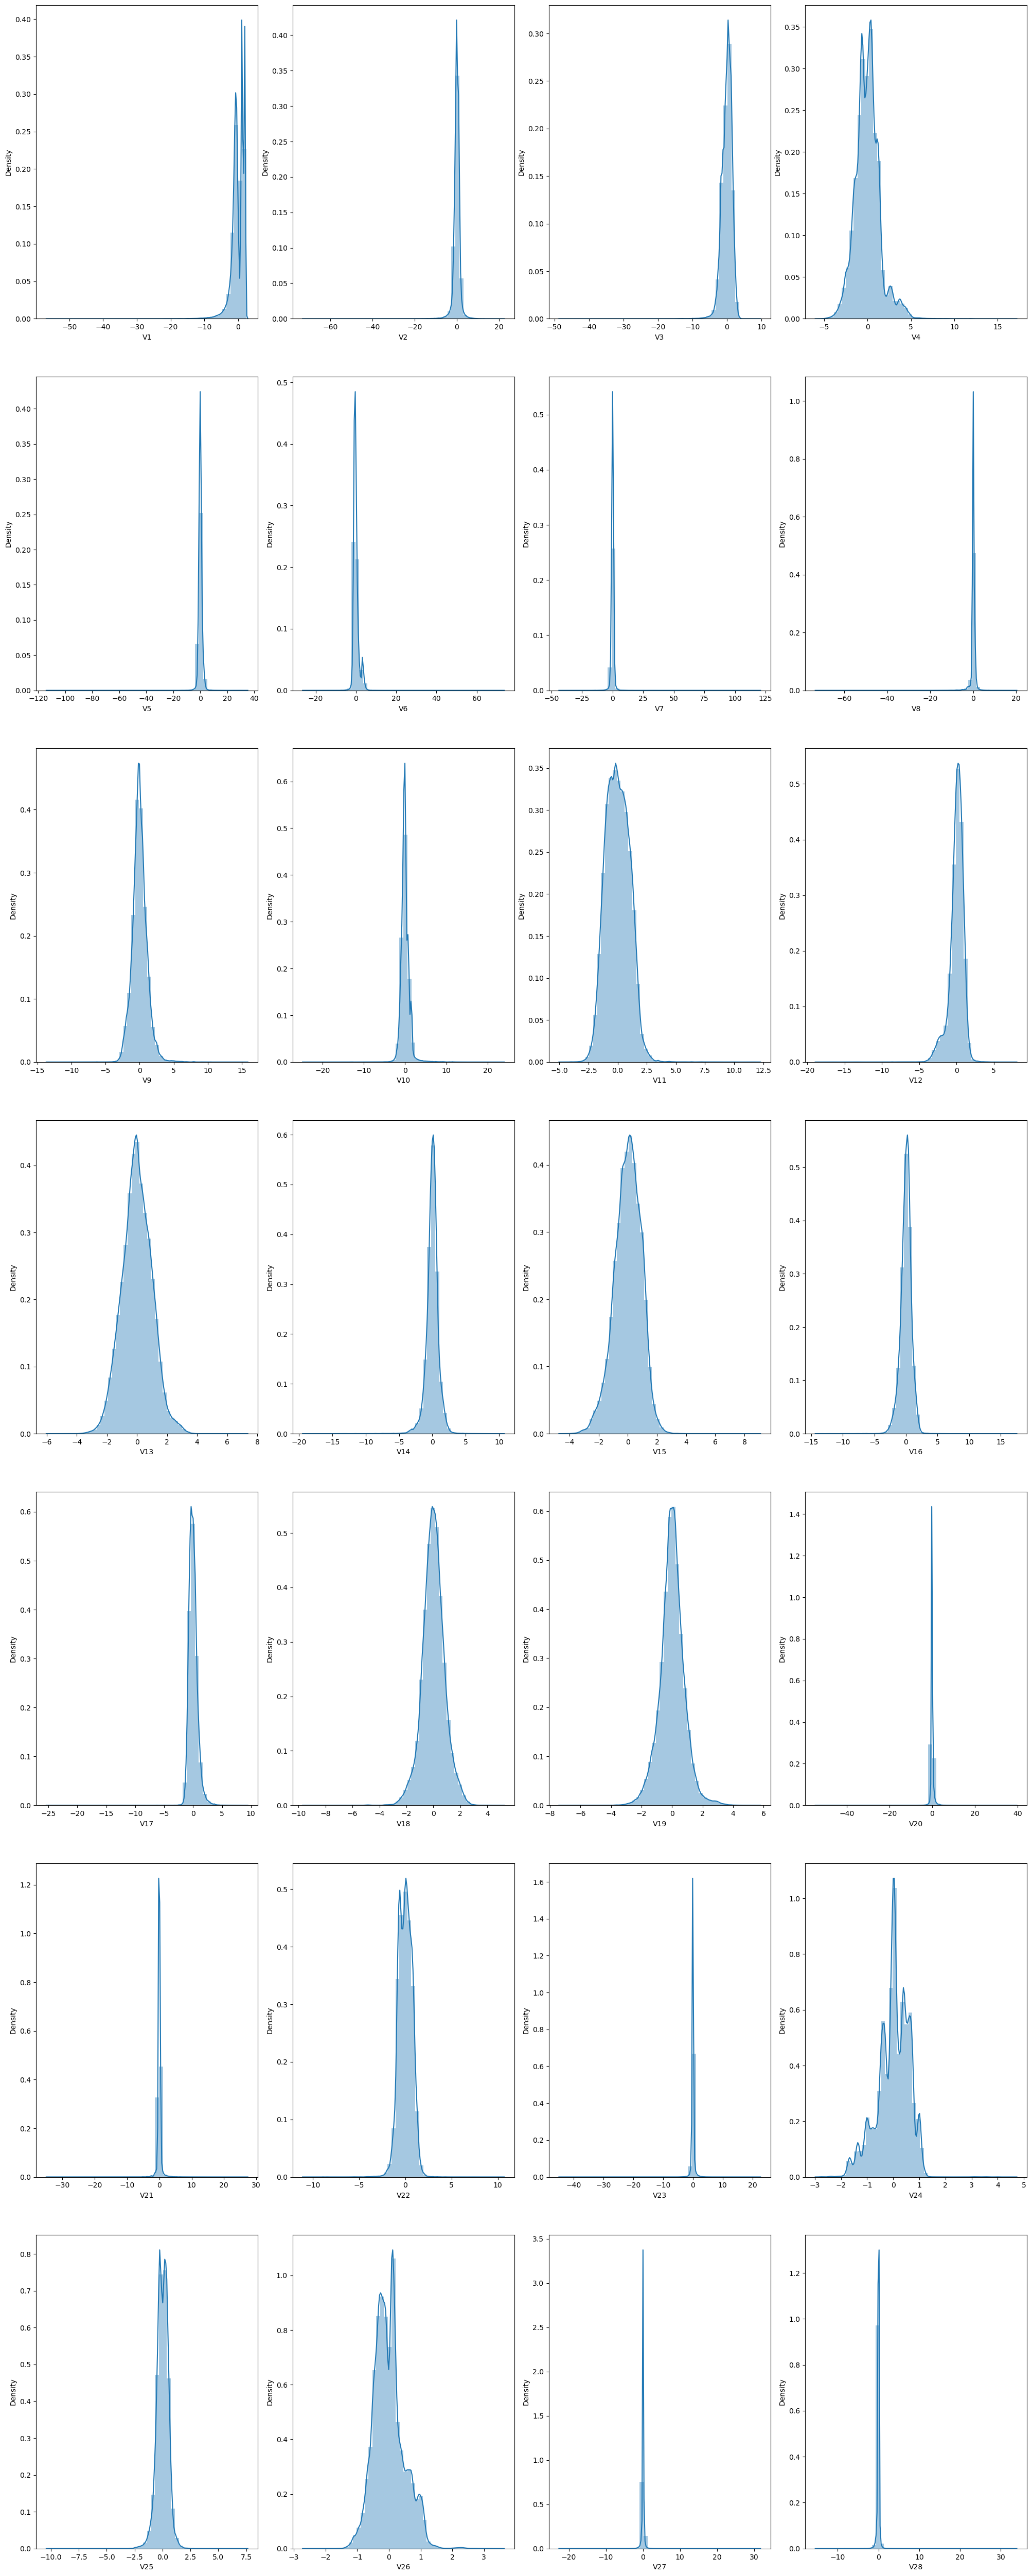

In [8]:
df_temp = df.drop(columns=['Time', 'Amount', 'Class'], axis=1)

# create dist plots
fig, ax = plt.subplots(ncols=4, nrows=7, figsize=(20, 50))
index = 0
ax = ax.flatten()

for col in df_temp.columns:
    sns.distplot(df_temp[col], ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5)

<AxesSubplot:xlabel='Time', ylabel='Density'>

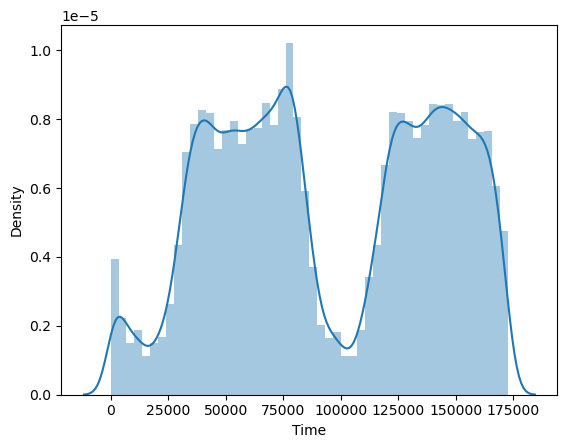

In [9]:
sns.distplot(df['Time'])

<AxesSubplot:xlabel='Amount', ylabel='Density'>

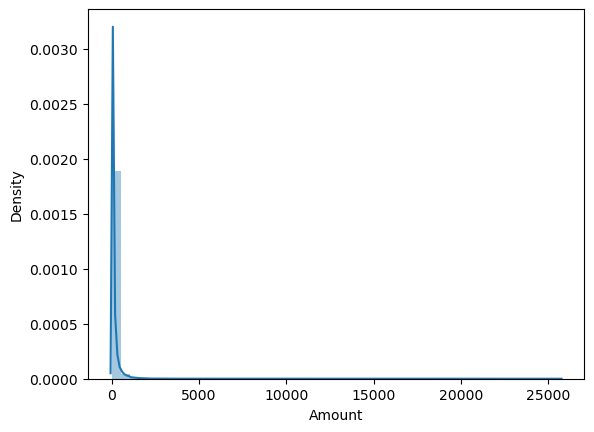

In [10]:
sns.distplot(df['Amount'])

## Coorelation Matrix



<AxesSubplot:>

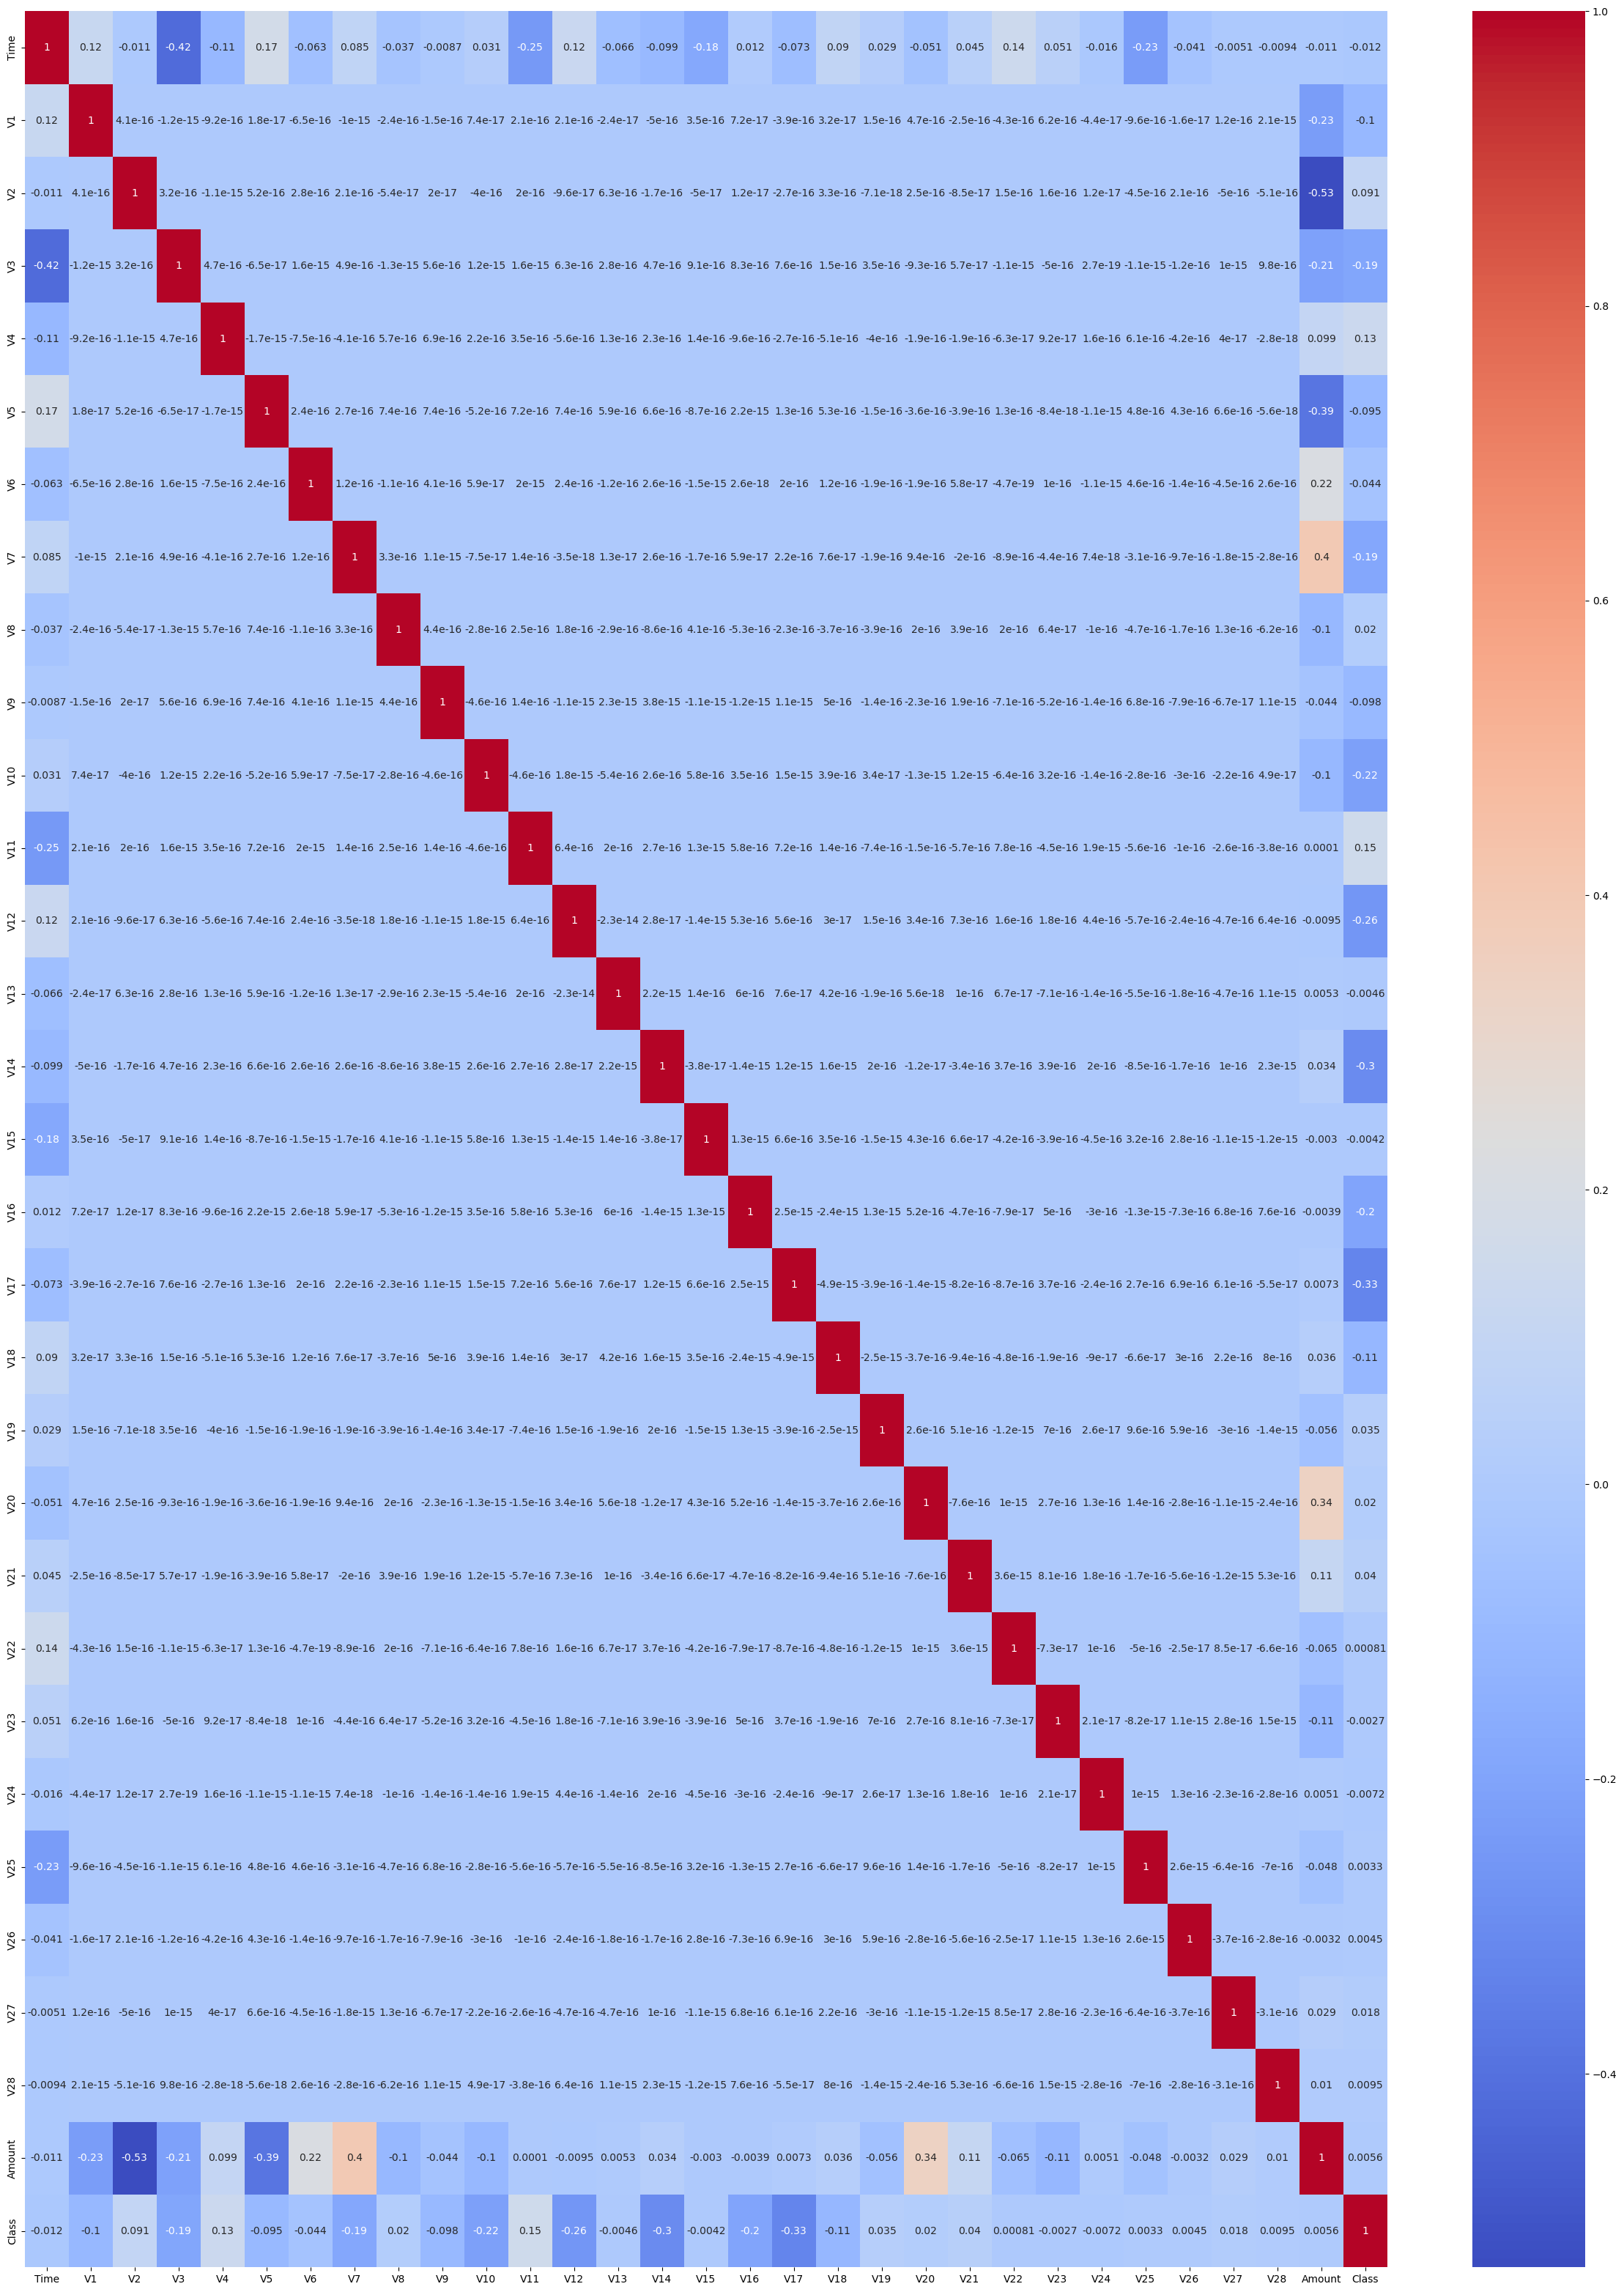

In [11]:
corr = df.corr()
plt.figure(figsize=(30,40))
sns.heatmap(corr, annot=True, cmap='coolwarm')

## Input Split

In [208]:
X = df.drop(columns=['Class'], axis=1)
y = df['Class']

In [209]:
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


## Standard Scaling

In [210]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_scaler = sc.fit_transform(X)

In [211]:
x_scaler.shape

(284807, 30)

In [212]:
x_scaler[-1]

array([ 1.64205773, -0.27233093, -0.11489898,  0.46386564, -0.35757   ,
       -0.00908946, -0.48760183,  1.27476937, -0.3471764 ,  0.44253246,
       -0.84072963, -1.01934641, -0.0315383 , -0.18898634, -0.08795849,
        0.04515766, -0.34535763, -0.77752147,  0.1997554 , -0.31462479,
        0.49673933,  0.35541083,  0.8861488 ,  0.6033653 ,  0.01452561,
       -0.90863123, -1.69685342, -0.00598394,  0.04134999,  0.51435531])

## Model Training

In [213]:
# train test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [214]:
counts = y.value_counts()

counts

0    284315
1       492
Name: Class, dtype: int64

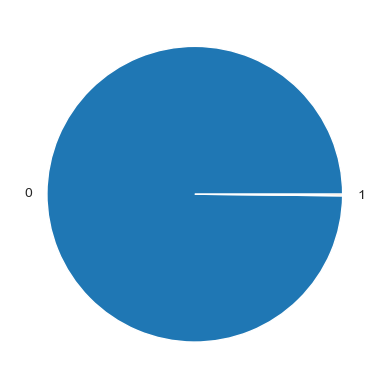

In [215]:
counts = y_train.value_counts()
labels = ["0","1"]
plt.pie(counts,labels = labels)
plt.show()

In [216]:
print(x_train.shape, y_train.shape)

(227845, 30) (227845,)


In [217]:
x_train,y_train = over_sampling(1, x_train, y_train)

In [218]:
print(x_train.shape, y_train.shape)

(454902, 30) (454902,)


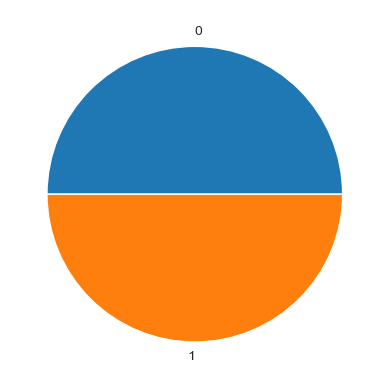

In [219]:
counts = y_train.value_counts()
labels = ["0","1"]
plt.pie(counts,labels = labels)
plt.show()

In [220]:
x_train.shape

(454902, 30)

In [221]:
n2 = len(y_train.loc[y_train == 0])
n1 = len(y_train.loc[y_train == 1])
print(n1,n2)

227451 227451


In [222]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
# training
model.fit(x_train, y_train)
# testing
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.48      0.84      0.61        98

    accuracy                           1.00     56962
   macro avg       0.74      0.92      0.81     56962
weighted avg       1.00      1.00      1.00     56962

F1 Score: 0.6119402985074627


In [223]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
# training
model.fit(x_train, y_train)
# testing
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.87      0.82        98

    accuracy                           1.00     56962
   macro avg       0.89      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

F1 Score: 0.821256038647343


In [224]:
from xgboost import XGBClassifier
model = XGBClassifier(n_jobs=-1)
# training
model.fit(x_train, y_train)
# testing
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

F1 Score: 0.8645833333333334


## Class Imbalancement

<AxesSubplot:xlabel='Class', ylabel='count'>

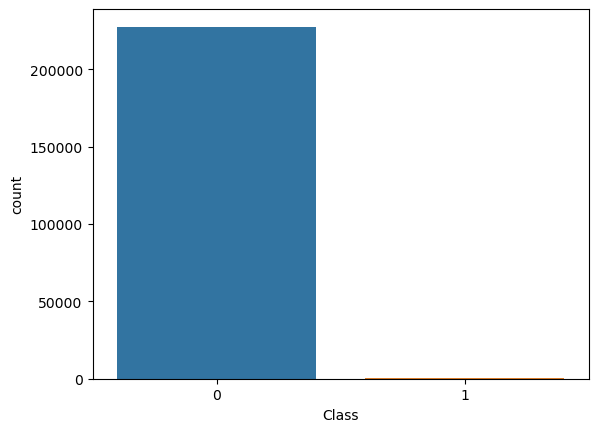

In [21]:
sns.countplot(y_train)

In [22]:
# hint - use combination of over sampling and under sampling
# balance the class with equal distribution
from imblearn.over_sampling import SMOTE
over_sample = SMOTE()
x_smote, y_smote = over_sample.fit_resample(x_train, y_train)

<AxesSubplot:xlabel='Class', ylabel='count'>

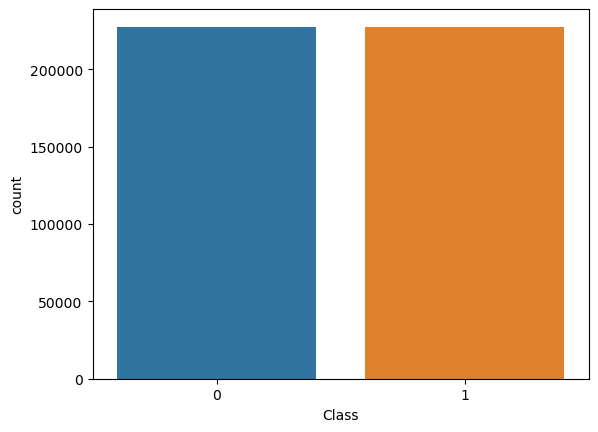

In [23]:
sns.countplot(y_smote)

In [24]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
# training
model.fit(x_smote, y_smote)
# testing
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

F1 Score: 0.1079136690647482


In [25]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs=-1)
# training
model.fit(x_smote, y_smote)
# testing
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.80      0.82        98

    accuracy                           1.00     56962
   macro avg       0.92      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962

F1 Score: 0.8210526315789473


In [26]:
from xgboost import XGBClassifier
model = XGBClassifier(n_jobs=-1)
# training
model.fit(x_smote, y_smote)
# testing
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.88      0.79        98

    accuracy                           1.00     56962
   macro avg       0.86      0.94      0.90     56962
weighted avg       1.00      1.00      1.00     56962

F1 Score: 0.792626728110599
